In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F

import math
import time

import skrf
from skrf import Network

import utils
import os

from skimage.metrics import peak_signal_noise_ratio as psnr

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Grab some data

In [3]:
ROOT_PATH = "/scratch/04703/sravula/UTAFSDataNew/new_data"
CHIP_NUM = 9

In [4]:
test_net = utils.get_network_from_file(ROOT_PATH, CHIP_NUM)['network']

In [5]:
print("S-parameters shape: ", test_net.s.shape)
print("S-parameters type: ", test_net.s.dtype)

S-parameters shape:  (1000, 4, 4)
S-parameters type:  complex128


In [6]:
N_PORTS = test_net.nports
N_FREQS = test_net.frequency.npoints

print("N_FREQS: ", N_FREQS)
print("N_PORTS: ", N_PORTS)

N_FREQS:  1000
N_PORTS:  4


In [7]:
reciprocity = skrf.network.reciprocity(test_net.s)

EPS_SMALL = 1e-6

IS_RECIPROCAL = False
if np.sum(np.abs(reciprocity)) < EPS_SMALL:
    IS_RECIPROCAL = True
    
print("RECIPROCAL: ", IS_RECIPROCAL)

RECIPROCAL:  True


# Look at the HLAS results 

In [8]:
case_str = "case" + (str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM))
case_fname = os.path.join(ROOT_PATH, case_str)

print(case_fname)

/scratch/04703/sravula/UTAFSDataNew/new_data/case09


In [9]:
children = os.listdir(case_fname)

time_fpth = [f for f in children if "TIME" in f][0]
time_fpth = os.path.join(case_fname, time_fpth)

HLAS_fpth = [f for f in children if "HLAS.s" in f][0]
HLAS_fpth = os.path.join(case_fname, HLAS_fpth)

HLAS_meas_fpth = [f for f in children if "SIMULATIONS" in f][0]
HLAS_meas_fpth = os.path.join(case_fname, HLAS_meas_fpth)

print(time_fpth)
print(HLAS_fpth)
print(HLAS_meas_fpth)

/scratch/04703/sravula/UTAFSDataNew/new_data/case09/SIEMENS_AFS_TIME_IN_SECONDS.txt
/scratch/04703/sravula/UTAFSDataNew/new_data/case09/case09.HLAS.s4p
/scratch/04703/sravula/UTAFSDataNew/new_data/case09/SIEMENS_AFS_SAMPLE_POINT_SIMULATIONS.s4p


In [10]:
HLAS_net = Network(HLAS_fpth)
HLAS_meas_net = Network(HLAS_meas_fpth)

with open(time_fpth) as file:
    lines = [line.rstrip() for line in file]
HLAS_time = lines[0]

In [11]:
print("HLAS time: ", HLAS_time)

HLAS time:  31.30984377861023


In [12]:
print("HLAS shape: ", HLAS_net.s.shape)
print("HLAS meas shape: ", HLAS_meas_net.s.shape)

HLAS shape:  (1000, 4, 4)
HLAS meas shape:  (132, 4, 4)


In [13]:
M_HLAS = HLAS_meas_net.s.shape[0]
print(M_HLAS)

132


In [14]:
test_net_twochan = np.stack((test_net.s.real, test_net.s.imag), axis=-1)
HLAS_net_twochan = np.stack((HLAS_net.s.real, HLAS_net.s.imag), axis=-1)

print(test_net_twochan.shape)
print(test_net_twochan.dtype)

print(HLAS_net_twochan.shape)
print(HLAS_net_twochan.dtype)

(1000, 4, 4, 2)
float64
(1000, 4, 4, 2)
float64


In [15]:
HLAS_psnr = psnr(test_net_twochan, HLAS_net_twochan)
print("HLAS PSNR: ", HLAS_psnr)

HLAS PSNR:  37.34894236920967


# Grab a toch tensor from this guy

In [16]:
x_test = utils.network_to_sparams(test_net)
print(x_test.shape)
print(x_test.dtype)

torch.Size([1, 20, 1000])
torch.float32


In [17]:
x_HLAS = utils.network_to_sparams(HLAS_net)
print(x_HLAS.shape)
print(x_HLAS.dtype)

torch.Size([1, 20, 1000])
torch.float32


In [18]:
y_HLAS = utils.network_to_sparams(HLAS_meas_net)
print(y_HLAS.shape)
print(y_HLAS.dtype)

torch.Size([1, 20, 132])
torch.float32


# Grab the initial measurements

In [19]:
MEASUREMENT_SPACING = "equal"
M_INIT = M_HLAS // 2 

KEPT_INDS_INIT, MISSING_INDS_INIT = utils.get_inds(MEASUREMENT_SPACING, N_FREQS, M_INIT)

M_INIT = len(KEPT_INDS_INIT)

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M_INIT)
print("Undersampling Ratio: ", M_INIT/N_FREQS)

Number of Ground Truth Frequency Points:  1000
Number of Measurements:  66
Undersampling Ratio:  0.066


In [20]:
y_init = torch.clone(x_test)[:, :, KEPT_INDS_INIT]

print("y_init shape: ", y_init.shape)

y_init shape:  torch.Size([1, 20, 66])


In [21]:
z_init = torch.clone(x_test)
z_init[:, :, MISSING_INDS_INIT] = 0

print("z_init shape: ", z_init.shape)

z_init shape:  torch.Size([1, 20, 1000])


# Plot the Data and measurements 

In [22]:
def plot_mags(sparams_list, freqs=None, chip_labels=None, not_reciprocal=False, plot_subset_list=None, ylims=False):
    mag_list = [utils.sparams_to_mag(sparam) for sparam in sparams_list]
    
    num_ports = (-1 + np.sqrt(8*mag_list[0].shape[1] + 1)) // 2
    num_ports = int(num_ports)
    if not_reciprocal:
        num_ports = int(np.sqrt(mag_list[0].shape[1] // 2))
    
    x = freqs if freqs is not None else [np.arange(mag_list[0].shape[-1])]*len(mag_list)
    labels = chip_labels if chip_labels is not None else np.arange(len(mag_list))
    
    if not_reciprocal:
        sparam_str_list = [str(s_idx//num_ports) + str(s_idx%num_ports) for s_idx in range(mag_list[0].shape[1])]
    else:
        sparam_str_list = []
        for i in range(num_ports):
            for j in range(i+1):
                sparam_str_list.append(str(i) + str(j))
    
    plot_chips = plot_subset_list if plot_subset_list is not None else np.arange(len(mag_list))
    
    fig, axs = plt.subplots((mag_list[0].shape[1] + 1) // 2, 2, figsize=(20,15))
    
    for s_idx in range(mag_list[0].shape[1]):
        if s_idx >= mag_list[0].shape[1]:
            break
        for chip_idx in plot_chips:
            axs[s_idx//2, s_idx%2].plot(x[chip_idx], mag_list[chip_idx][0, s_idx], label=str(labels[chip_idx]))
        axs[s_idx//2, s_idx%2].set_title(sparam_str_list[s_idx])
        axs[s_idx//2, s_idx%2].legend()
        if ylims:
            axs[s_idx//2, s_idx%2].set_ylim(0, 1)
        
    fig.tight_layout()

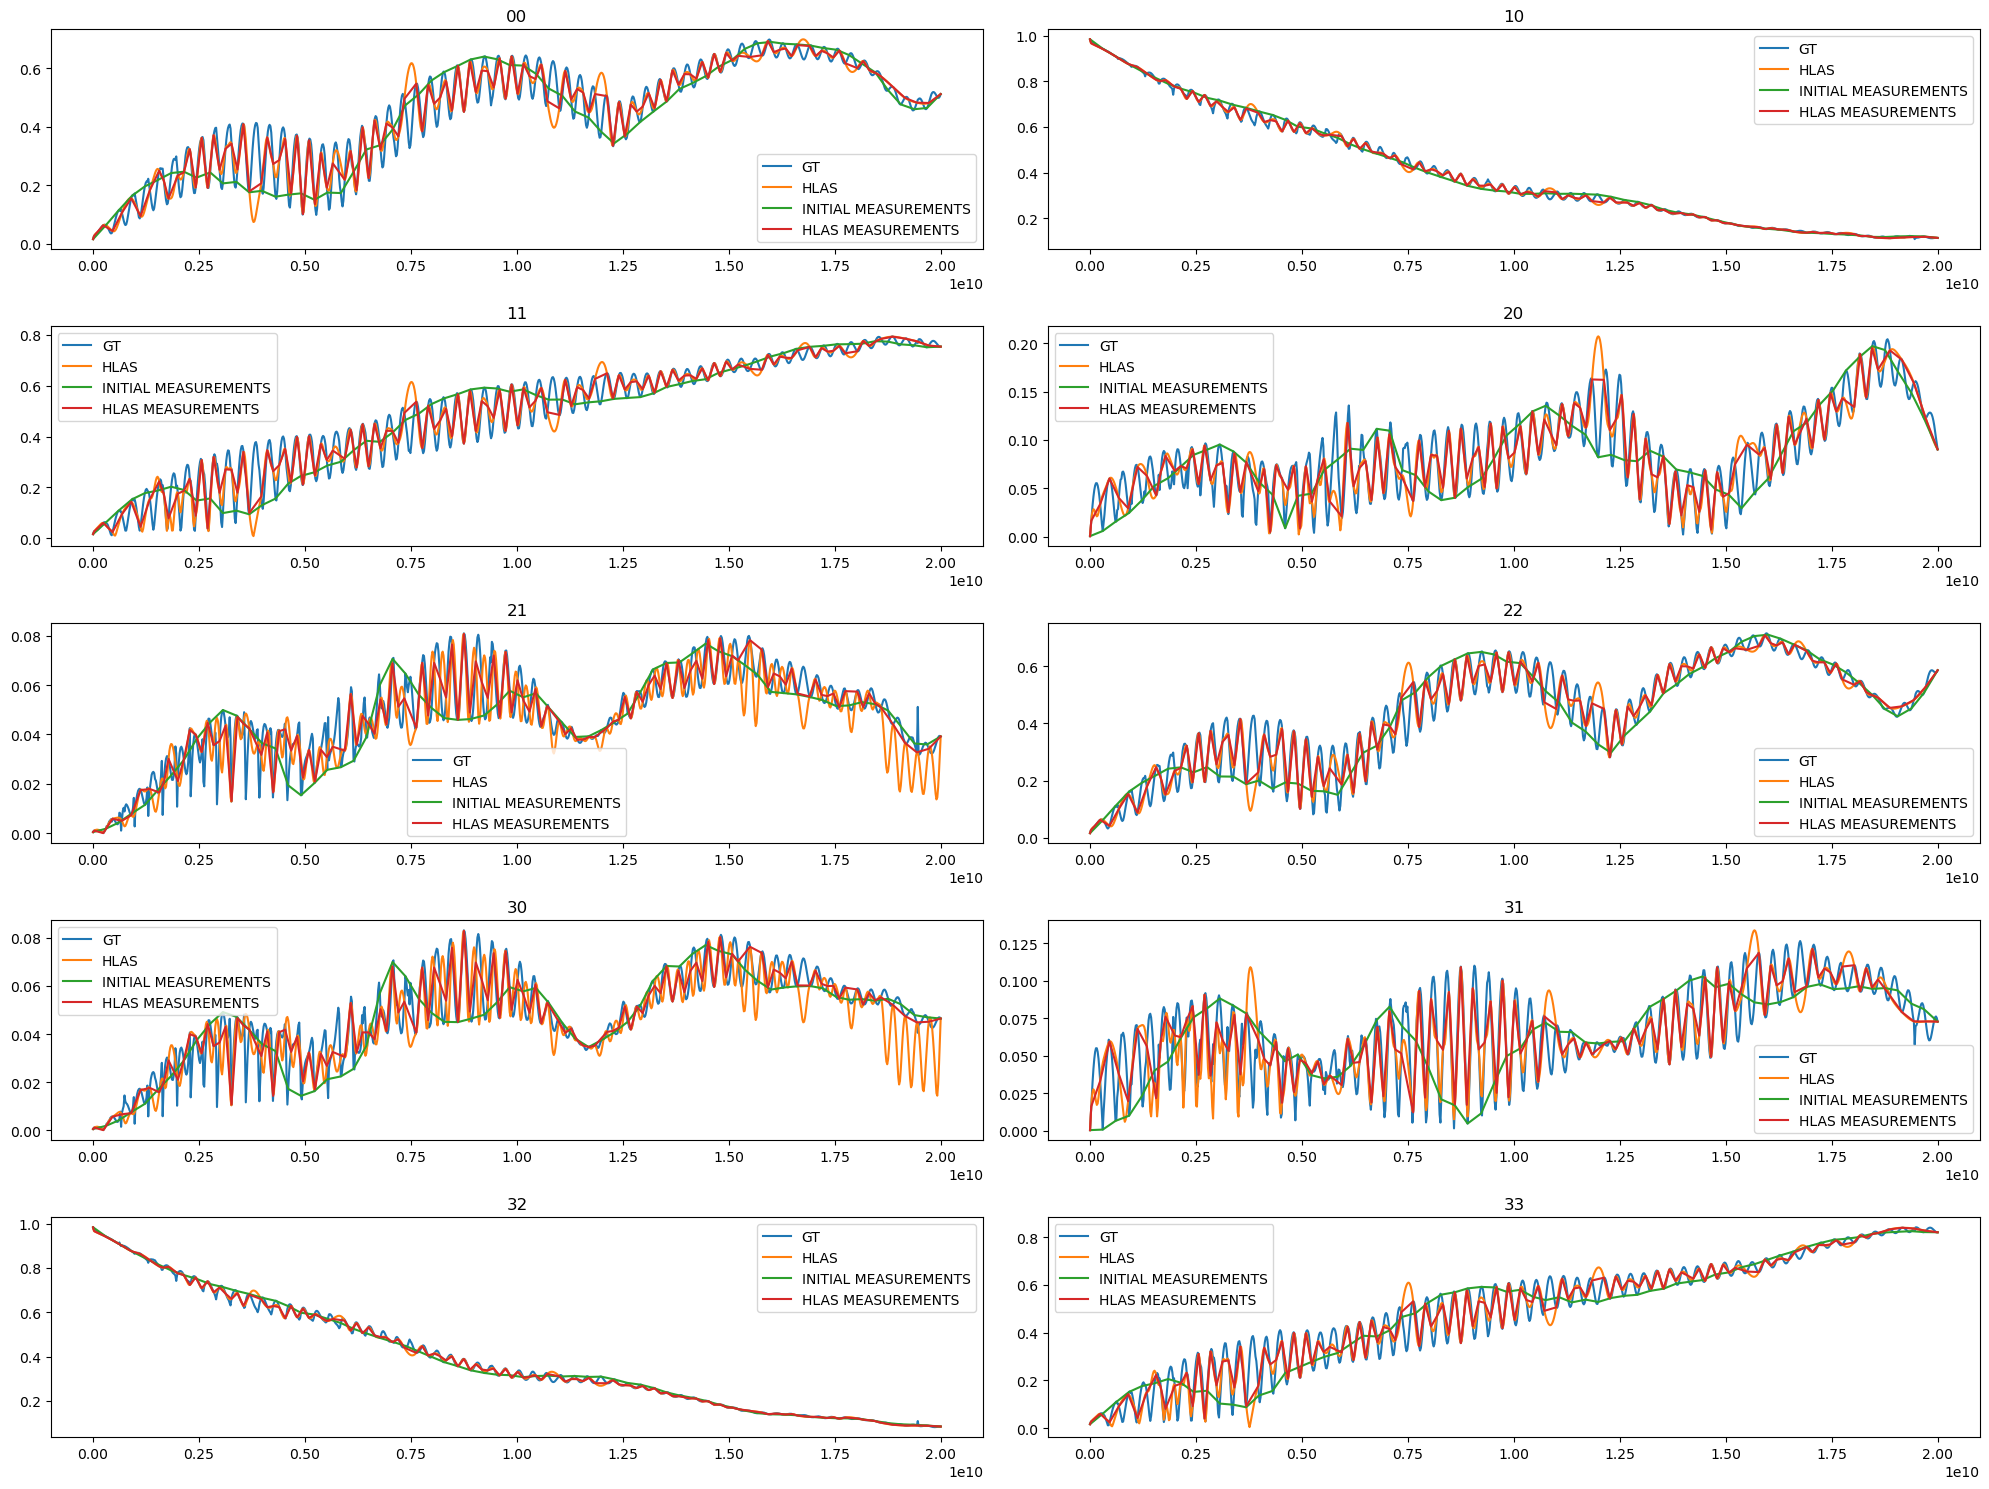

In [23]:
plot_mags([x_test, x_HLAS, y_init, y_HLAS], 
          freqs=[test_net.f, test_net.f, test_net.f[KEPT_INDS_INIT], HLAS_meas_net.f], 
          chip_labels=["GT", "HLAS", "INITIAL MEASUREMENTS", "HLAS MEASUREMENTS"], 
          not_reciprocal=(not IS_RECIPROCAL),
          plot_subset_list=[0,1,2,3],
          ylims=False)

# Make the network(s)

In [24]:
NC = NZ = y_init.shape[-2]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 3
    
# BASE_NGF = int(30 * np.sqrt(NZ))
if NZ < 64:
    BASE_NGF = 256
elif NZ < 128:
    BASE_NGF = 512
else:
    BASE_NGF = 1024
    
KERNEL_SIZE = 3
CAUSAL = True
PASSIVE = False

K = 1 #interpolation factor
NEW_CAUSAL = True

In [25]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("CAUSAL: ", CAUSAL)
print("PASSIVE: ", PASSIVE)
print("K: ", K)
print("NEW_CAUSAL", NEW_CAUSAL)

NZ:  20
NUM_LAYERS:  7
BASE NGF:  256
NC:  20
KERNEL_SIZE:  3
CAUSAL:  True
PASSIVE:  False
K:  1
NEW_CAUSAL True


In [26]:
from models import RESNET_BACKBONE, RESNET_HEAD, MODULAR_RESNET

NUM_DIP = 3

net_list = []

for i in range(NUM_DIP):
    net_backbone = RESNET_BACKBONE(ngf=BASE_NGF,
                                   ngf_in_out=BASE_NGF,
                                   kernel_size=KERNEL_SIZE,
                                   num_layers=NUM_LAYERS)
    net_head = RESNET_HEAD(nz=NZ,
                           ngf_in_out=BASE_NGF,
                           nc=NC,
                           kernel_size=KERNEL_SIZE,
                           causal=CAUSAL,
                           passive=PASSIVE,
                           k=K,
                           new_causality=NEW_CAUSAL)

    net = MODULAR_RESNET(backbone=net_backbone,
                         head=net_head)
    net_list.append(net.to(device))

In [27]:
print(len(net_list))

3


In [28]:
pytorch_total_params = sum(p.numel() for p in net_list[0].parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  8682072
